In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

Using TensorFlow backend.


Keys in the dataset: KeysView(<numpy.lib.npyio.NpzFile object at 0x7f6a913d1d68>)


/home/shared/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


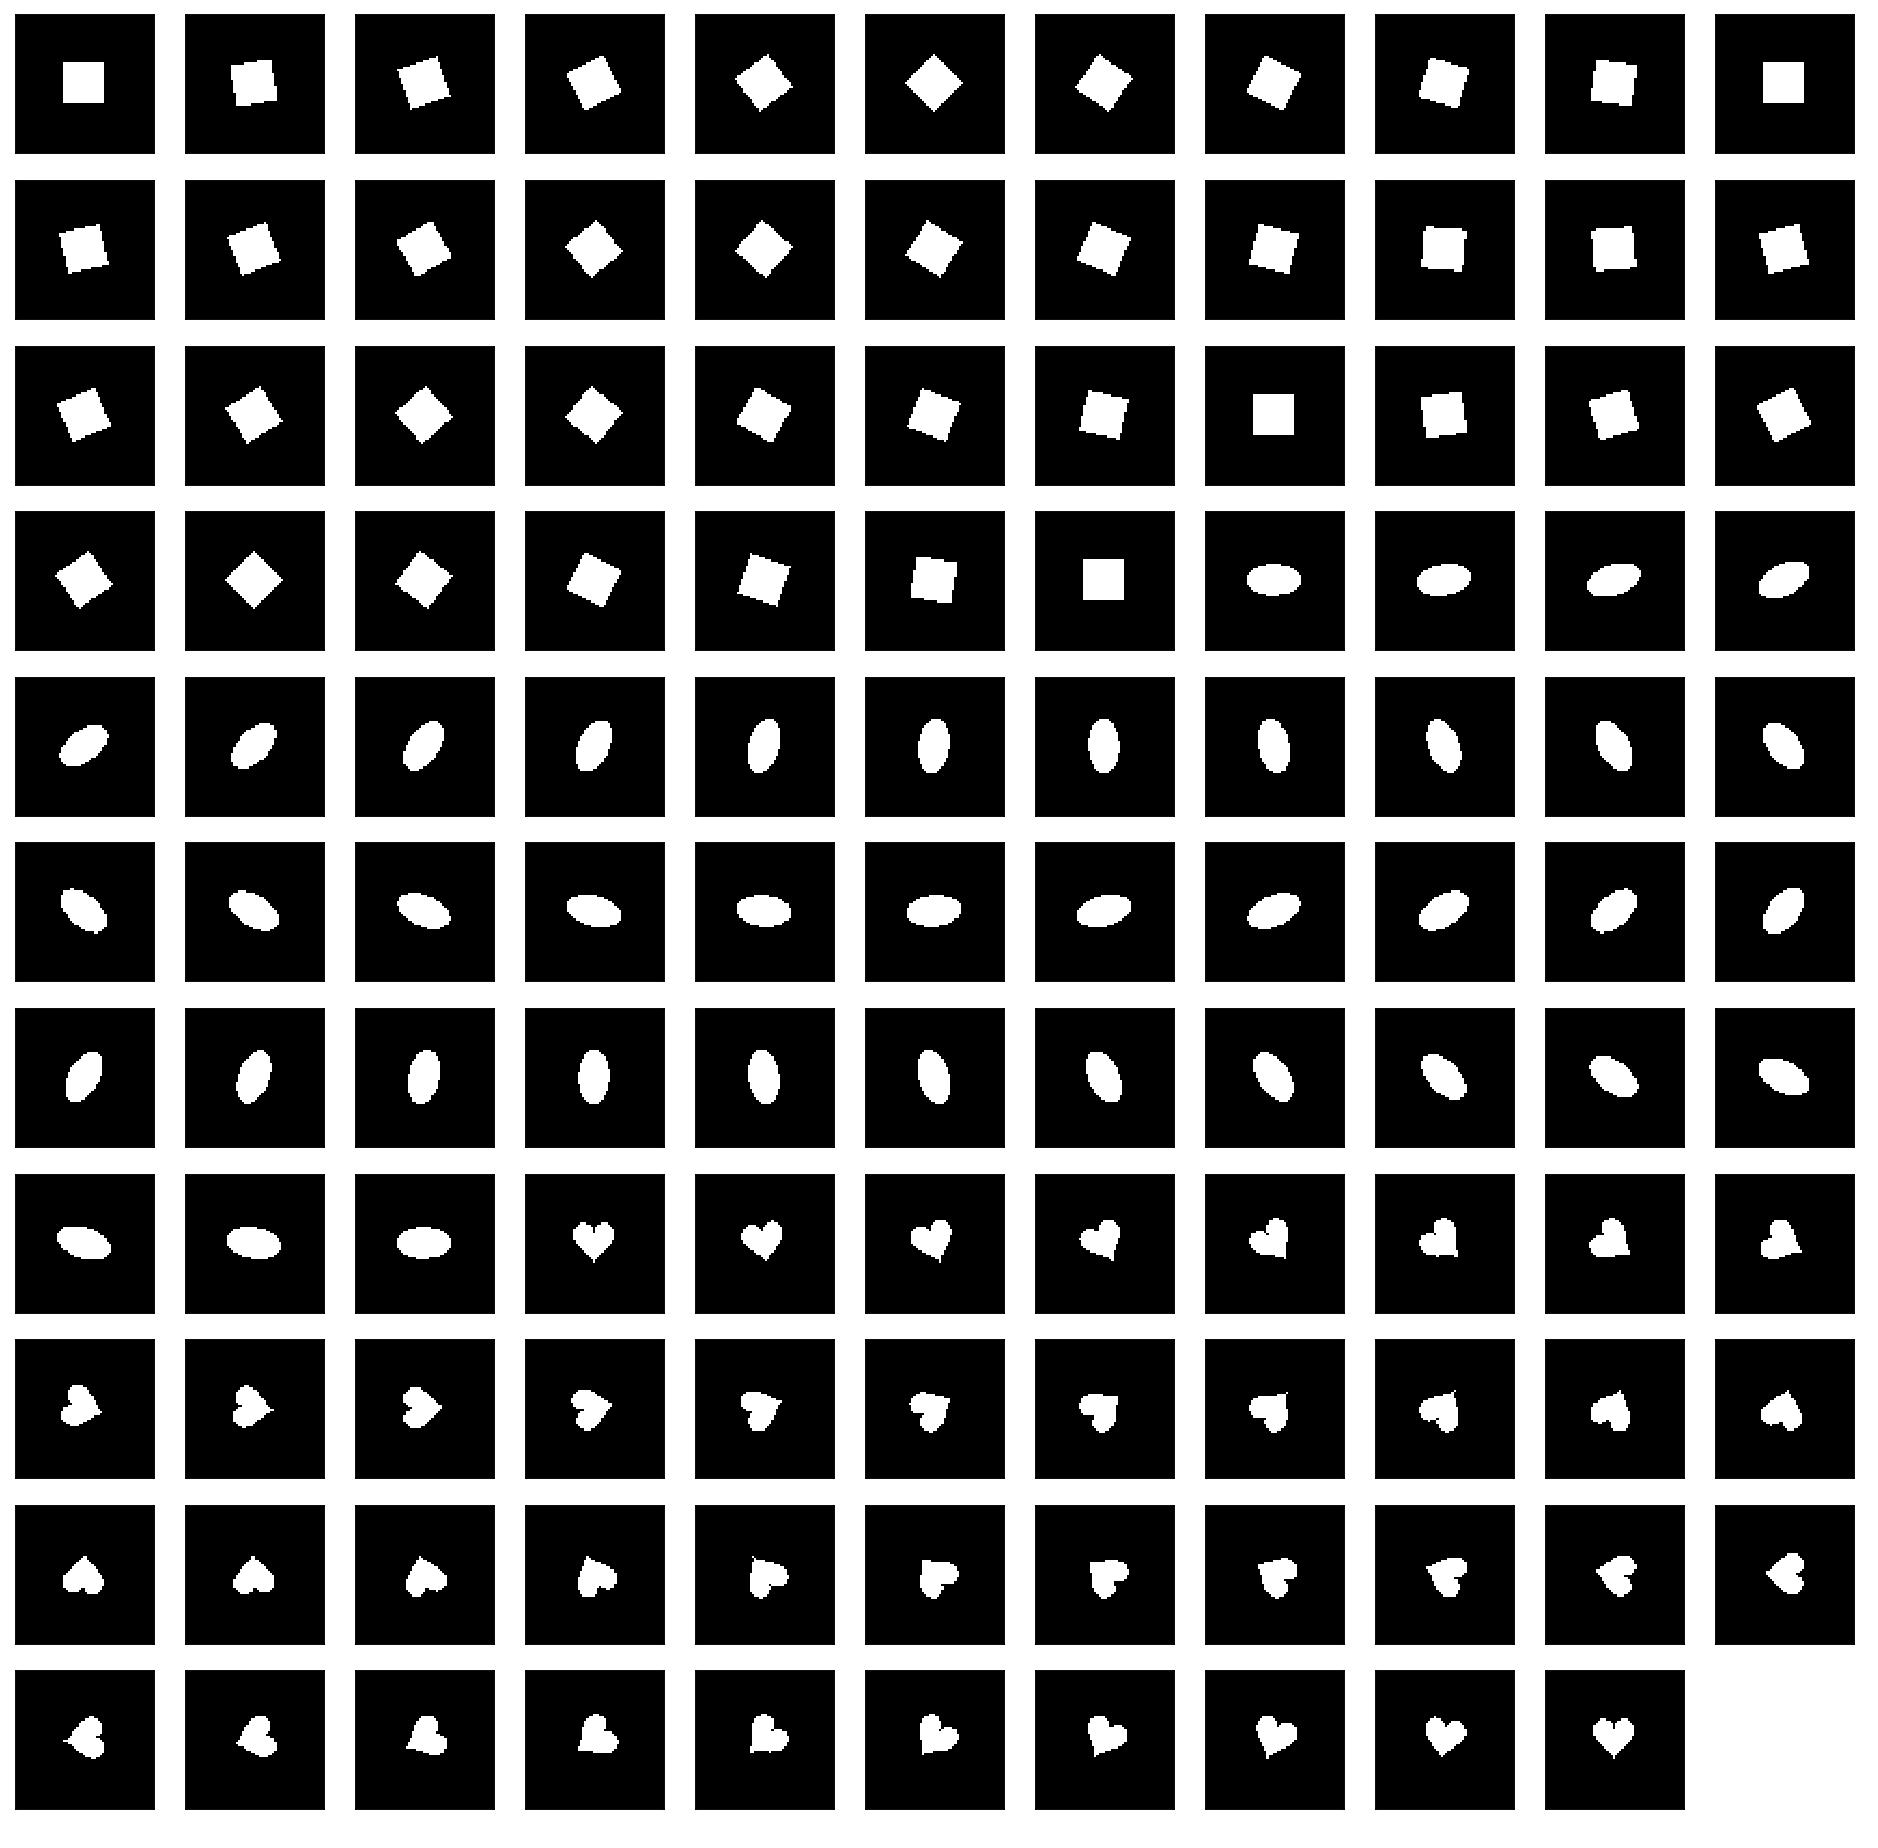

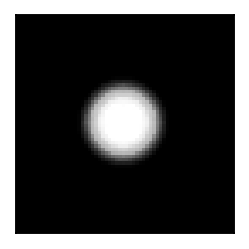

In [2]:
import seaborn as sns

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})

# Load dataset
dataset_zip = np.load('dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
                      , encoding='bytes')

print('Keys in the dataset:', dataset_zip.keys())
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
metadata = dataset_zip['metadata'][()]

# Define number of values per latents and functions to convert to indices
latents_sizes =  np.array([ 1,  3,  6, 40, 32, 32])
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

def latent_to_index(latents):
  return np.dot(latents, latents_bases).astype(int)

# Helper function to show images
def show_images_grid(imgs_, num_images=25):
  ncols = int(np.ceil(num_images**0.5))
  nrows = int(np.ceil(num_images / ncols))
  _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
  axes = axes.flatten()

  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      ax.imshow(imgs_[ax_i], cmap='Greys_r',  interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      ax.axis('off')

def show_density(imgs):
  _, ax = plt.subplots()
  ax.imshow(imgs.mean(axis=0), interpolation='nearest', cmap='Greys_r')
  ax.grid('off')
  ax.set_xticks([])
  ax.set_yticks([])

from copy import deepcopy
## Fix posX latent to left
#latents_sampled = sample_latent(size=5000)
latents_sampled = deepcopy(latents_classes)
latents_sampled[:, [4,5]] = 15
latents_sampled[:,2]= 5


indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[np.unique(indices_sampled)]

#np.unique(indices_sampled)

# Samples
show_images_grid(imgs_sampled,len(np.unique(indices_sampled)))

# Show the density too to check
show_density(imgs_sampled)



In [3]:
import random
random.seed(69)
ff = imgs_sampled
n_data =  ff.shape[0]
n_train = int(np.ceil(n_data*0.8))

print(n_train)
idx_train = random.sample(range(n_data), n_train)
idx_test = np.delete(range(n_data),idx_train,0)

96


In [4]:
ff.shape[0]*0.8
idx_test

array([  0,   1,   6,  14,  15,  20,  22,  23,  24,  28,  32,  43,  46,
        51,  55,  67,  85,  92,  93,  96, 104, 105, 110, 118])

In [5]:
# split data into train / validation folds
#np.random.seed(42)

img_rows = ff.shape[1]
img_cols = ff.shape[2]

n_pixels = img_rows * img_cols
x_train = ff[idx_train]
x_test = ff[idx_test]
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')
x_train = x_train.reshape((len(x_train), n_pixels))
x_test = x_test.reshape((len(x_test), n_pixels))

In [6]:
x_train.shape

(96, 4096)

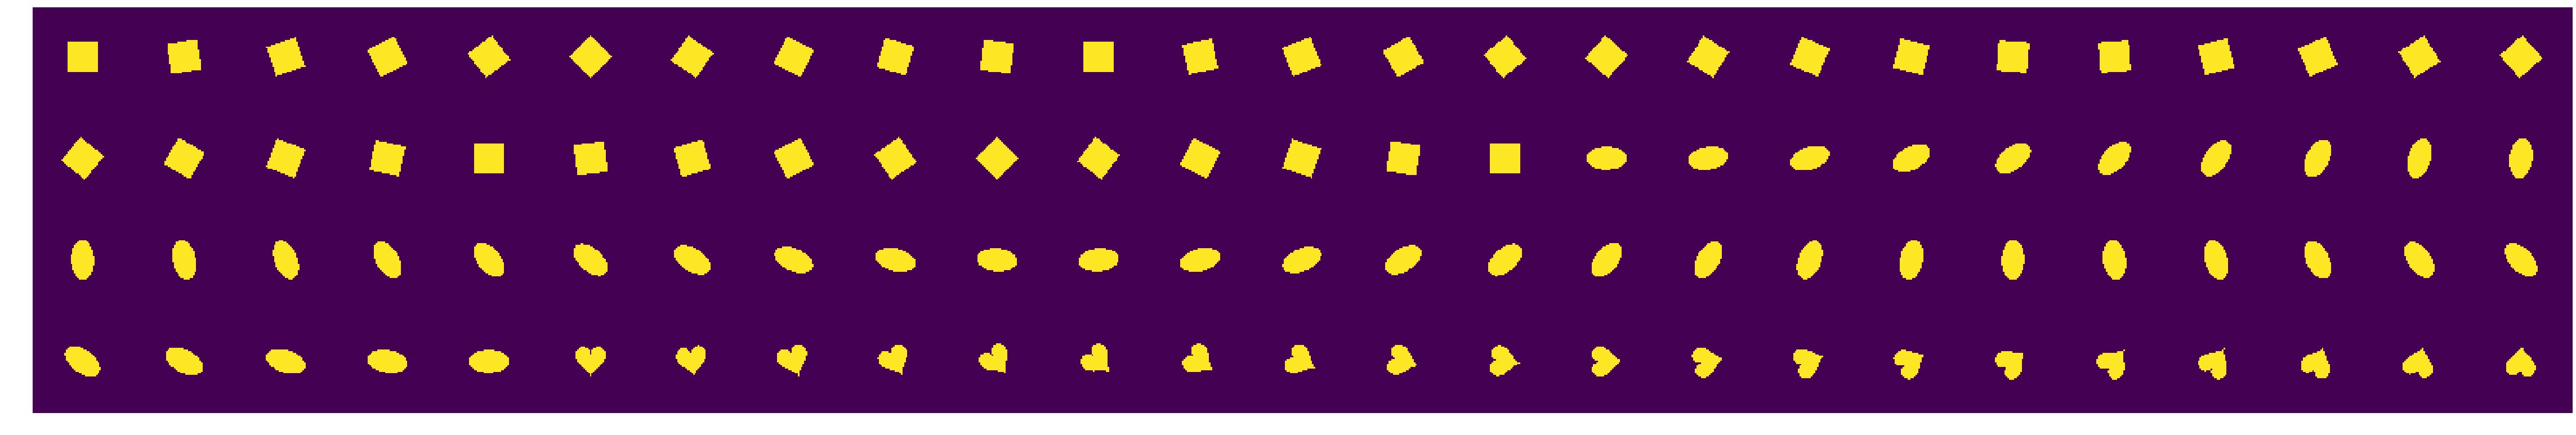

In [7]:
def show_examples(data, n=None, n_cols=20, thumbnail_cb=None):
    if n is None:
        n = len(data)    
    n_rows = int(np.ceil(n / float(n_cols)))
    figure = np.zeros((img_rows * n_rows, img_cols * n_cols))
    for k, x in enumerate(data[:n]):
        r = k // n_cols
        c = k % n_cols
        figure[r * img_rows: (r + 1) * img_rows,
               c * img_cols: (c + 1) * img_cols] = x
        if thumbnail_cb is not None:
            thumbnail_cb(locals())
        
    plt.figure(figsize=(64, 64))
    plt.imshow(figure)
    plt.axis("off")
    plt.tight_layout()
show_examples(ff, n=100, n_cols=25)

In [8]:
import tensorflow as tf
sess = tf.Session()

K.set_session(sess)

In [9]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)

    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon
#     return z_mean + K.exp(0.5 ) * epsilon

In [10]:
def plot_results(models,
                 latent_dim,
                 latent_num,
                 z_m_m, 
                 batch_size=128,
                 model_name="vae_face"):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    #x_test = data
    latent_dim = latent_dim
    os.makedirs(model_name, exist_ok=True)

    
    
    """filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()
    """

    filename = os.path.join(model_name, "face_over_latent.png")
    n = 20
    #digit_size = 28
    img_rows, img_cols = 64, 64
    figure = np.zeros((img_rows , img_cols * n))
    grid_x = np.linspace(-5, 5, n)
    #grid_y = np.linspace(-5, 5, n)[::-1]
    z_sample = np.zeros((1,latent_dim))
    z_sample[0,:] = z_m_m 
    
    for j, xi in enumerate(grid_x):
        z_sample[0,latent_num] = xi
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_rows, img_cols)
        figure[0: img_rows,j * img_cols: (j + 1) * img_cols] = digit

    plt.figure(figsize=(20, 20))
    #start_range = digit_size // 2
    #end_range = n * digit_size + start_range + 1
    #pixel_range = np.arange(start_range, end_range, digit_size)
    #sample_range_x = np.round(grid_x, 1)
    #sample_range_y = np.round(grid_y, 1)
    #plt.xticks(pixel_range, sample_range_x)
    #plt.yticks(pixel_range, sample_range_y)
    #plt.xlabel("z[0]")
    #plt.ylabel("z[1]")
    plt.axis('off')
    plt.imshow(figure, cmap='gray')
    plt.savefig(filename)
    plt.show()

In [11]:
# network parameters
original_dim = n_pixels
input_shape = (original_dim, )
intermediate_dim1 = 512
intermediate_dim2 = 256
intermediate_dim3 = 64

batch_size = 20
latent_dim = 2
epochs = 100

In [12]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x1 = Dense(intermediate_dim1, activation='relu')(inputs)
x2 = Dense(intermediate_dim2, activation='relu')(x1)
x3 = Dense(intermediate_dim3, activation='relu')(x2)

z_mean = Dense(latent_dim, name='z_mean')(x3)
z_log_var = Dense(latent_dim, name='z_log_var')(x3)


In [13]:
# standardize the mean of z, so that mean(m_z)=0 and cov(m_z)=I
def standardize(z_mean):
    z_m_m = K.mean(z_mean,axis=0, keepdims=True)
    z1 = z_mean - z_m_m
    n = tf.cast(K.shape(z_mean)[0], tf.float32)
    cov = K.transpose(z1) @ z1 /n
    
    D = tf.diag(tf.diag_part(cov)) ** 0.5
    
    L = tf.linalg.inv(tf.transpose(tf.cholesky(cov)))
       
#     z2 = z1 @ L @ D +  z_m_m
    z2 = z1 @ L  +  z_m_m

    return( z2)

In [14]:
z_mean_std = Lambda(standardize, output_shape=(latent_dim,), name='z_mean_std')(z_mean)

In [15]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
#z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean_std, z_log_var])
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 4096)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          2097664     encoder_input[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          131328      dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 64)           16448       dense_2[0][0]                    
__________________________________________________________________________________________________
z_mean (De

In [16]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z')

x3 = Dense(intermediate_dim3, activation='relu')(latent_inputs)
x2 = Dense(intermediate_dim2, activation='relu')(x3)
x1 = Dense(intermediate_dim1, activation='relu')(x2)

# x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x1)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z (InputLayer)               (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_5 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_7 (Dense)              (None, 4096)              2101248   
Total params: 2,249,664
Trainable params: 2,249,664
Non-trainable params: 0
_________________________________________________________________


In [17]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [18]:
models = (encoder, decoder)
data = (x_test )

# VAE loss = mse_loss or xent_loss + kl_loss

#     reconstruction_loss = mse(inputs, outputs)
reconstruction_loss = binary_crossentropy(inputs,
                                              outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 4096)              0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 2245700   
_________________________________________________________________
decoder (Model)              (None, 4096)              2249664   
Total params: 4,495,364
Trainable params: 4,495,364
Non-trainable params: 0
_________________________________________________________________


In [19]:
epochs = int(1E3)

In [20]:
from keras.callbacks import ModelCheckpoint

'''
saves the model weights after each epoch if the validation loss decreased
'''
checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)
#model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=0, validation_data=(X_test, Y_test), callbacks=[checkpointer])
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None), 
        callbacks=[checkpointer])

Train on 96 samples, validate on 24 samples
Epoch 1/1000
96/96 [==============================] - 1s 11ms/step - loss: 2734.7971 - val_loss: 2154.1434

Epoch 00001: val_loss improved from inf to 2154.14335, saving model to weights.hdf5
Epoch 2/1000
96/96 [==============================] - 0s 535us/step - loss: 1591.5355 - val_loss: 550.0900

Epoch 00002: val_loss improved from 2154.14335 to 550.09000, saving model to weights.hdf5
Epoch 3/1000
96/96 [==============================] - 0s 539us/step - loss: 449.6288 - val_loss: 357.4591

Epoch 00003: val_loss improved from 550.09000 to 357.45908, saving model to weights.hdf5
Epoch 4/1000
96/96 [==============================] - 0s 530us/step - loss: 314.0213 - val_loss: 282.4471

Epoch 00004: val_loss improved from 357.45908 to 282.44713, saving model to weights.hdf5
Epoch 5/1000
96/96 [==============================] - 0s 543us/step - loss: 257.0769 - val_loss: 248.0404

Epoch 00005: val_loss improved from 282.44713 to 248.04038, saving 

96/96 [==============================] - 0s 626us/step - loss: 157.1230 - val_loss: 182.6076

Epoch 00046: val_loss improved from 185.46419 to 182.60764, saving model to weights.hdf5
Epoch 47/1000
96/96 [==============================] - 0s 571us/step - loss: 157.2992 - val_loss: 186.0230

Epoch 00047: val_loss did not improve from 182.60764
Epoch 48/1000
96/96 [==============================] - 0s 591us/step - loss: 155.4708 - val_loss: 186.6545

Epoch 00048: val_loss did not improve from 182.60764
Epoch 49/1000
96/96 [==============================] - 0s 622us/step - loss: 159.3916 - val_loss: 186.0630

Epoch 00049: val_loss did not improve from 182.60764
Epoch 50/1000
96/96 [==============================] - 0s 614us/step - loss: 156.2470 - val_loss: 190.3699

Epoch 00050: val_loss did not improve from 182.60764
Epoch 51/1000
96/96 [==============================] - 0s 618us/step - loss: 156.7370 - val_loss: 191.0281

Epoch 00051: val_loss did not improve from 182.60764
Epoch 52/100

Epoch 96/1000
96/96 [==============================] - 0s 534us/step - loss: 143.7767 - val_loss: 181.9436

Epoch 00096: val_loss did not improve from 174.33687
Epoch 97/1000
96/96 [==============================] - 0s 575us/step - loss: 147.2806 - val_loss: 178.6864

Epoch 00097: val_loss did not improve from 174.33687
Epoch 98/1000
96/96 [==============================] - 0s 599us/step - loss: 145.3598 - val_loss: 176.7509

Epoch 00098: val_loss did not improve from 174.33687
Epoch 99/1000
96/96 [==============================] - 0s 633us/step - loss: 142.6564 - val_loss: 181.0430

Epoch 00099: val_loss did not improve from 174.33687
Epoch 100/1000
96/96 [==============================] - 0s 627us/step - loss: 144.3429 - val_loss: 176.7386

Epoch 00100: val_loss did not improve from 174.33687
Epoch 101/1000
96/96 [==============================] - 0s 627us/step - loss: 141.7639 - val_loss: 179.8559

Epoch 00101: val_loss did not improve from 174.33687
Epoch 102/1000
96/96 [==========

Epoch 144/1000
96/96 [==============================] - 0s 555us/step - loss: 121.2668 - val_loss: 163.2228

Epoch 00144: val_loss did not improve from 141.67689
Epoch 145/1000
96/96 [==============================] - 0s 584us/step - loss: 122.6563 - val_loss: 150.4047

Epoch 00145: val_loss did not improve from 141.67689
Epoch 146/1000
96/96 [==============================] - 0s 605us/step - loss: 121.1132 - val_loss: 144.4247

Epoch 00146: val_loss did not improve from 141.67689
Epoch 147/1000
96/96 [==============================] - 0s 628us/step - loss: 128.0379 - val_loss: 155.4973

Epoch 00147: val_loss did not improve from 141.67689
Epoch 148/1000
96/96 [==============================] - 0s 618us/step - loss: 119.4545 - val_loss: 141.9253

Epoch 00148: val_loss did not improve from 141.67689
Epoch 149/1000
96/96 [==============================] - 0s 621us/step - loss: 120.8083 - val_loss: 154.2718

Epoch 00149: val_loss did not improve from 141.67689
Epoch 150/1000
96/96 [======

96/96 [==============================] - 0s 643us/step - loss: 94.3685 - val_loss: 151.1672

Epoch 00194: val_loss did not improve from 136.08881
Epoch 195/1000
96/96 [==============================] - 0s 619us/step - loss: 96.9153 - val_loss: 154.3106

Epoch 00195: val_loss did not improve from 136.08881
Epoch 196/1000
96/96 [==============================] - 0s 647us/step - loss: 100.7534 - val_loss: 150.7843

Epoch 00196: val_loss did not improve from 136.08881
Epoch 197/1000
96/96 [==============================] - 0s 618us/step - loss: 100.5405 - val_loss: 159.9276

Epoch 00197: val_loss did not improve from 136.08881
Epoch 198/1000
96/96 [==============================] - 0s 601us/step - loss: 96.1933 - val_loss: 136.1549

Epoch 00198: val_loss did not improve from 136.08881
Epoch 199/1000
96/96 [==============================] - 0s 650us/step - loss: 93.4581 - val_loss: 157.6005

Epoch 00199: val_loss did not improve from 136.08881
Epoch 200/1000
96/96 [=========================

96/96 [==============================] - 0s 615us/step - loss: 81.0800 - val_loss: 147.6965

Epoch 00245: val_loss did not improve from 132.92938
Epoch 246/1000
96/96 [==============================] - 0s 628us/step - loss: 81.2828 - val_loss: 152.2398

Epoch 00246: val_loss did not improve from 132.92938
Epoch 247/1000
96/96 [==============================] - 0s 630us/step - loss: 77.8033 - val_loss: 146.2869

Epoch 00247: val_loss did not improve from 132.92938
Epoch 248/1000
96/96 [==============================] - 0s 621us/step - loss: 83.0897 - val_loss: 154.0516

Epoch 00248: val_loss did not improve from 132.92938
Epoch 249/1000
96/96 [==============================] - 0s 626us/step - loss: 88.5698 - val_loss: 157.8582

Epoch 00249: val_loss did not improve from 132.92938
Epoch 250/1000
96/96 [==============================] - 0s 629us/step - loss: 79.3559 - val_loss: 154.5384

Epoch 00250: val_loss did not improve from 132.92938
Epoch 251/1000
96/96 [===========================

96/96 [==============================] - 0s 619us/step - loss: 64.9736 - val_loss: 161.5289

Epoch 00296: val_loss did not improve from 132.92938
Epoch 297/1000
96/96 [==============================] - 0s 614us/step - loss: 82.5958 - val_loss: 168.0100

Epoch 00297: val_loss did not improve from 132.92938
Epoch 298/1000
96/96 [==============================] - 0s 627us/step - loss: 70.5301 - val_loss: 164.9264

Epoch 00298: val_loss did not improve from 132.92938
Epoch 299/1000
96/96 [==============================] - 0s 607us/step - loss: 71.6345 - val_loss: 153.3011

Epoch 00299: val_loss did not improve from 132.92938
Epoch 300/1000
96/96 [==============================] - 0s 622us/step - loss: 76.8589 - val_loss: 168.1870

Epoch 00300: val_loss did not improve from 132.92938
Epoch 301/1000
96/96 [==============================] - 0s 624us/step - loss: 67.9205 - val_loss: 157.7085

Epoch 00301: val_loss did not improve from 132.92938
Epoch 302/1000
96/96 [===========================

96/96 [==============================] - 0s 623us/step - loss: 79.2686 - val_loss: 158.7386

Epoch 00347: val_loss did not improve from 132.92938
Epoch 348/1000
96/96 [==============================] - 0s 606us/step - loss: 74.3816 - val_loss: 153.8971

Epoch 00348: val_loss did not improve from 132.92938
Epoch 349/1000
96/96 [==============================] - 0s 619us/step - loss: 65.3787 - val_loss: 161.1012

Epoch 00349: val_loss did not improve from 132.92938
Epoch 350/1000
96/96 [==============================] - 0s 629us/step - loss: 96.1918 - val_loss: 152.0412

Epoch 00350: val_loss did not improve from 132.92938
Epoch 351/1000
96/96 [==============================] - 0s 624us/step - loss: 79.6343 - val_loss: 159.2888

Epoch 00351: val_loss did not improve from 132.92938
Epoch 352/1000
96/96 [==============================] - 0s 641us/step - loss: 71.6549 - val_loss: 147.9195

Epoch 00352: val_loss did not improve from 132.92938
Epoch 353/1000
96/96 [===========================

96/96 [==============================] - 0s 633us/step - loss: 63.2069 - val_loss: 154.9718

Epoch 00398: val_loss did not improve from 132.92938
Epoch 399/1000
96/96 [==============================] - 0s 622us/step - loss: 60.4652 - val_loss: 156.9376

Epoch 00399: val_loss did not improve from 132.92938
Epoch 400/1000
96/96 [==============================] - 0s 616us/step - loss: 64.2982 - val_loss: 151.1987

Epoch 00400: val_loss did not improve from 132.92938
Epoch 401/1000
96/96 [==============================] - 0s 633us/step - loss: 54.0143 - val_loss: 148.6910

Epoch 00401: val_loss did not improve from 132.92938
Epoch 402/1000
96/96 [==============================] - 0s 624us/step - loss: 70.8207 - val_loss: 148.9721

Epoch 00402: val_loss did not improve from 132.92938
Epoch 403/1000
96/96 [==============================] - 0s 625us/step - loss: 59.3630 - val_loss: 152.6273

Epoch 00403: val_loss did not improve from 132.92938
Epoch 404/1000
96/96 [===========================

96/96 [==============================] - 0s 618us/step - loss: 59.7752 - val_loss: 156.8671

Epoch 00449: val_loss did not improve from 132.92938
Epoch 450/1000
96/96 [==============================] - 0s 621us/step - loss: 54.7327 - val_loss: 151.9531

Epoch 00450: val_loss did not improve from 132.92938
Epoch 451/1000
96/96 [==============================] - 0s 633us/step - loss: 66.9437 - val_loss: 151.0052

Epoch 00451: val_loss did not improve from 132.92938
Epoch 452/1000
96/96 [==============================] - 0s 622us/step - loss: 65.6265 - val_loss: 146.5829

Epoch 00452: val_loss did not improve from 132.92938
Epoch 453/1000
96/96 [==============================] - 0s 621us/step - loss: 56.1000 - val_loss: 153.5081

Epoch 00453: val_loss did not improve from 132.92938
Epoch 454/1000
96/96 [==============================] - 0s 618us/step - loss: 65.1410 - val_loss: 152.9508

Epoch 00454: val_loss did not improve from 132.92938
Epoch 455/1000
96/96 [===========================

96/96 [==============================] - 0s 631us/step - loss: 53.5482 - val_loss: 168.5904

Epoch 00500: val_loss did not improve from 132.92938
Epoch 501/1000
96/96 [==============================] - 0s 620us/step - loss: 57.4969 - val_loss: 163.4366

Epoch 00501: val_loss did not improve from 132.92938
Epoch 502/1000
96/96 [==============================] - 0s 616us/step - loss: 54.7050 - val_loss: 154.3233

Epoch 00502: val_loss did not improve from 132.92938
Epoch 503/1000
96/96 [==============================] - 0s 626us/step - loss: 46.2534 - val_loss: 156.2976

Epoch 00503: val_loss did not improve from 132.92938
Epoch 504/1000
96/96 [==============================] - 0s 620us/step - loss: 61.3401 - val_loss: 161.9968

Epoch 00504: val_loss did not improve from 132.92938
Epoch 505/1000
96/96 [==============================] - 0s 614us/step - loss: 67.6709 - val_loss: 158.7798

Epoch 00505: val_loss did not improve from 132.92938
Epoch 506/1000
96/96 [===========================

96/96 [==============================] - 0s 632us/step - loss: 61.7082 - val_loss: 156.5027

Epoch 00551: val_loss did not improve from 132.92938
Epoch 552/1000
96/96 [==============================] - 0s 621us/step - loss: 98.0384 - val_loss: 156.6182

Epoch 00552: val_loss did not improve from 132.92938
Epoch 553/1000
96/96 [==============================] - 0s 634us/step - loss: 84.2754 - val_loss: 154.9107

Epoch 00553: val_loss did not improve from 132.92938
Epoch 554/1000
96/96 [==============================] - 0s 621us/step - loss: 85.3045 - val_loss: 179.9828

Epoch 00554: val_loss did not improve from 132.92938
Epoch 555/1000
96/96 [==============================] - 0s 654us/step - loss: 82.5747 - val_loss: 178.5894

Epoch 00555: val_loss did not improve from 132.92938
Epoch 556/1000
96/96 [==============================] - 0s 615us/step - loss: 77.7184 - val_loss: 176.9520

Epoch 00556: val_loss did not improve from 132.92938
Epoch 557/1000
96/96 [===========================

96/96 [==============================] - 0s 618us/step - loss: 77.7266 - val_loss: 161.2518

Epoch 00602: val_loss did not improve from 132.92938
Epoch 603/1000
96/96 [==============================] - 0s 623us/step - loss: 53.3614 - val_loss: 153.9298

Epoch 00603: val_loss did not improve from 132.92938
Epoch 604/1000
96/96 [==============================] - 0s 619us/step - loss: 54.0609 - val_loss: 173.9436

Epoch 00604: val_loss did not improve from 132.92938
Epoch 605/1000
96/96 [==============================] - 0s 627us/step - loss: 51.8281 - val_loss: 158.2046

Epoch 00605: val_loss did not improve from 132.92938
Epoch 606/1000
96/96 [==============================] - 0s 627us/step - loss: 47.2107 - val_loss: 155.1305

Epoch 00606: val_loss did not improve from 132.92938
Epoch 607/1000
96/96 [==============================] - 0s 613us/step - loss: 51.7965 - val_loss: 156.9471

Epoch 00607: val_loss did not improve from 132.92938
Epoch 608/1000
96/96 [===========================

96/96 [==============================] - 0s 630us/step - loss: 47.6195 - val_loss: 171.5453

Epoch 00653: val_loss did not improve from 132.92938
Epoch 654/1000
96/96 [==============================] - 0s 615us/step - loss: 40.3121 - val_loss: 176.6921

Epoch 00654: val_loss did not improve from 132.92938
Epoch 655/1000
96/96 [==============================] - 0s 631us/step - loss: 55.0018 - val_loss: 172.5236

Epoch 00655: val_loss did not improve from 132.92938
Epoch 656/1000
96/96 [==============================] - 0s 617us/step - loss: 54.5825 - val_loss: 178.5382

Epoch 00656: val_loss did not improve from 132.92938
Epoch 657/1000
96/96 [==============================] - 0s 626us/step - loss: 55.0558 - val_loss: 178.4217

Epoch 00657: val_loss did not improve from 132.92938
Epoch 658/1000
96/96 [==============================] - 0s 632us/step - loss: 50.7588 - val_loss: 187.8812

Epoch 00658: val_loss did not improve from 132.92938
Epoch 659/1000
96/96 [===========================

96/96 [==============================] - 0s 624us/step - loss: 51.0369 - val_loss: 191.7340

Epoch 00704: val_loss did not improve from 132.92938
Epoch 705/1000
96/96 [==============================] - 0s 620us/step - loss: 65.5964 - val_loss: 173.4060

Epoch 00705: val_loss did not improve from 132.92938
Epoch 706/1000
96/96 [==============================] - 0s 616us/step - loss: 58.2084 - val_loss: 171.3313

Epoch 00706: val_loss did not improve from 132.92938
Epoch 707/1000
96/96 [==============================] - 0s 623us/step - loss: 47.1647 - val_loss: 178.4361

Epoch 00707: val_loss did not improve from 132.92938
Epoch 708/1000
96/96 [==============================] - 0s 623us/step - loss: 47.4145 - val_loss: 180.0155

Epoch 00708: val_loss did not improve from 132.92938
Epoch 709/1000
96/96 [==============================] - 0s 626us/step - loss: 66.0020 - val_loss: 210.2857

Epoch 00709: val_loss did not improve from 132.92938
Epoch 710/1000
96/96 [===========================

96/96 [==============================] - 0s 624us/step - loss: 60.6330 - val_loss: 190.2359

Epoch 00755: val_loss did not improve from 132.92938
Epoch 756/1000
96/96 [==============================] - 0s 614us/step - loss: 47.7622 - val_loss: 190.6828

Epoch 00756: val_loss did not improve from 132.92938
Epoch 757/1000
96/96 [==============================] - 0s 619us/step - loss: 45.7001 - val_loss: 192.9324

Epoch 00757: val_loss did not improve from 132.92938
Epoch 758/1000
96/96 [==============================] - 0s 633us/step - loss: 46.8039 - val_loss: 189.9337

Epoch 00758: val_loss did not improve from 132.92938
Epoch 759/1000
96/96 [==============================] - 0s 627us/step - loss: 38.8618 - val_loss: 185.0134

Epoch 00759: val_loss did not improve from 132.92938
Epoch 760/1000
96/96 [==============================] - 0s 602us/step - loss: 47.1108 - val_loss: 189.0333

Epoch 00760: val_loss did not improve from 132.92938
Epoch 761/1000
96/96 [===========================

96/96 [==============================] - 0s 629us/step - loss: 53.3962 - val_loss: 176.6355

Epoch 00806: val_loss did not improve from 132.92938
Epoch 807/1000
96/96 [==============================] - 0s 628us/step - loss: 50.9243 - val_loss: 175.0098

Epoch 00807: val_loss did not improve from 132.92938
Epoch 808/1000
96/96 [==============================] - 0s 625us/step - loss: 55.9747 - val_loss: 174.6010

Epoch 00808: val_loss did not improve from 132.92938
Epoch 809/1000
96/96 [==============================] - 0s 619us/step - loss: 69.3365 - val_loss: 184.3459

Epoch 00809: val_loss did not improve from 132.92938
Epoch 810/1000
96/96 [==============================] - 0s 616us/step - loss: 61.6366 - val_loss: 187.4262

Epoch 00810: val_loss did not improve from 132.92938
Epoch 811/1000
96/96 [==============================] - 0s 624us/step - loss: 57.2636 - val_loss: 181.5602

Epoch 00811: val_loss did not improve from 132.92938
Epoch 812/1000
96/96 [===========================

96/96 [==============================] - 0s 612us/step - loss: 47.3026 - val_loss: 185.7420

Epoch 00857: val_loss did not improve from 132.92938
Epoch 858/1000
96/96 [==============================] - 0s 615us/step - loss: 60.3136 - val_loss: 187.7455

Epoch 00858: val_loss did not improve from 132.92938
Epoch 859/1000
96/96 [==============================] - 0s 617us/step - loss: 56.2143 - val_loss: 187.1045

Epoch 00859: val_loss did not improve from 132.92938
Epoch 860/1000
96/96 [==============================] - 0s 616us/step - loss: 42.5003 - val_loss: 209.0562

Epoch 00860: val_loss did not improve from 132.92938
Epoch 861/1000
96/96 [==============================] - 0s 625us/step - loss: 72.0620 - val_loss: 187.9988

Epoch 00861: val_loss did not improve from 132.92938
Epoch 862/1000
96/96 [==============================] - 0s 620us/step - loss: 49.1927 - val_loss: 182.1625

Epoch 00862: val_loss did not improve from 132.92938
Epoch 863/1000
96/96 [===========================

96/96 [==============================] - 0s 613us/step - loss: 52.1997 - val_loss: 216.3400

Epoch 00908: val_loss did not improve from 132.92938
Epoch 909/1000
96/96 [==============================] - 0s 618us/step - loss: 57.1980 - val_loss: 184.2151

Epoch 00909: val_loss did not improve from 132.92938
Epoch 910/1000
96/96 [==============================] - 0s 611us/step - loss: 62.9133 - val_loss: 183.8972

Epoch 00910: val_loss did not improve from 132.92938
Epoch 911/1000
96/96 [==============================] - 0s 622us/step - loss: 48.9230 - val_loss: 179.8173

Epoch 00911: val_loss did not improve from 132.92938
Epoch 912/1000
96/96 [==============================] - 0s 614us/step - loss: 41.9807 - val_loss: 179.9567

Epoch 00912: val_loss did not improve from 132.92938
Epoch 913/1000
96/96 [==============================] - 0s 619us/step - loss: 41.7828 - val_loss: 184.2334

Epoch 00913: val_loss did not improve from 132.92938
Epoch 914/1000
96/96 [===========================

96/96 [==============================] - 0s 629us/step - loss: 67.4775 - val_loss: 189.3867

Epoch 00959: val_loss did not improve from 132.92938
Epoch 960/1000
96/96 [==============================] - 0s 621us/step - loss: 59.1395 - val_loss: 193.4916

Epoch 00960: val_loss did not improve from 132.92938
Epoch 961/1000
96/96 [==============================] - 0s 623us/step - loss: 49.0093 - val_loss: 183.2703

Epoch 00961: val_loss did not improve from 132.92938
Epoch 962/1000
96/96 [==============================] - 0s 633us/step - loss: 46.1078 - val_loss: 185.7465

Epoch 00962: val_loss did not improve from 132.92938
Epoch 963/1000
96/96 [==============================] - 0s 618us/step - loss: 38.7137 - val_loss: 190.6364

Epoch 00963: val_loss did not improve from 132.92938
Epoch 964/1000
96/96 [==============================] - 0s 633us/step - loss: 38.4648 - val_loss: 185.3187

Epoch 00964: val_loss did not improve from 132.92938
Epoch 965/1000
96/96 [===========================

In [21]:
z_output = sess.run( z_mean_std, feed_dict={'encoder_input: 0':x_train})

In [22]:
z_m_m = np.mean(z_output,axis=0)
z_m_m

array([0.00054633, 0.02389398], dtype=float32)

In [23]:
np.cov(z_output.T)

array([[1.01052657e+00, 6.28591109e-09],
       [6.28591109e-09, 1.01052615e+00]])

Plot the Pearson correlation among Z

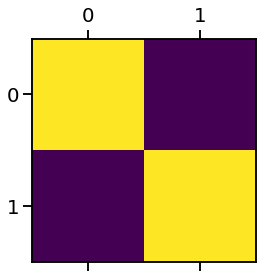

In [24]:
plt.matshow(np.corrcoef(z_output.T))

In [25]:
z_m_m

array([0.00054633, 0.02389398], dtype=float32)

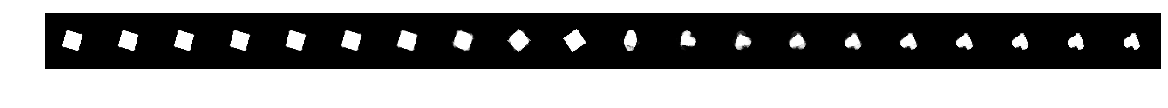

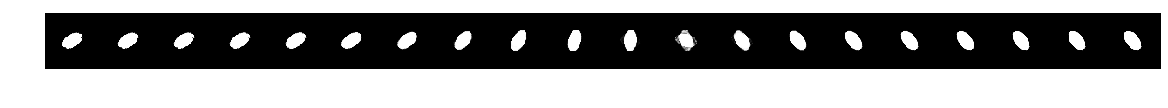

In [26]:
for i in range(0, latent_dim):
    plot_results(models,
                 latent_dim,
                 latent_num = i,
                 z_m_m = z_m_m ,
                 batch_size=batch_size,
                 model_name="vae_mlp")